In [1]:
# Load modules
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns; sns.set(rc={'figure.figsize':(8,8)})
import matplotlib.pyplot as plt
import copy
from scipy import stats

In [2]:
# Load gene expression dataset and reorder expression data columns to match order of metabolite data columns
exprData = pd.read_csv(filepath_or_buffer="../microtomGeneExpression.csv", header=2)
exprData = exprData.set_index("Gene")
exprData = exprData[["Chromosome", "Start", "End", "Strand", "Description",
"R30", "R45", "R85", "S30", "S45", "S85", "L30", "L45", "L85", "F30", "F45", "10DPA", "20DPA", "IMG", "MG", "Br", "Br3", "Br7", "Br10", "Br15"]]

# Load metabolite accumulation dataset
metDataTF = pd.read_csv(filepath_or_buffer="subsetMetDataTF.csv")
metDataTF = metDataTF.set_index("Index")

# Create dataframes with only data
onlyExprData = exprData.iloc[:, exprData.shape[1]-20:exprData.shape[1]]
onlyExprData.index = exprData.index
onlyMetDataTF = metDataTF.iloc[:, metDataTF.shape[1]-20:metDataTF.shape[1]]
onlyMetDataTF.index = metDataTF.index

In [3]:
# Normalize the gene expression dataset using a sample-wise z-score normalization
onlyExprDataTF = stats.zscore(onlyExprData, axis=1)
onlyExprDataTF = pd.DataFrame(onlyExprDataTF, columns=onlyExprData.columns, index=onlyExprData.index)
exprDataTF = exprData.iloc[:, 0:exprData.shape[1]-20]
exprDataTF = pd.concat([exprDataTF, onlyExprDataTF], axis=1)

In [4]:
# Only needs to be run once!
# Creates a correlation matrix - each row represents a metabolite, and each column a gene.
metExprPCC = np.zeros(shape=(onlyMetDataTF.shape[0], onlyExprDataTF.shape[0]))
for row in range(0, metExprPCC.shape[0]):
    for col in range(0, metExprPCC.shape[1]):
        metExprPCC[row, col] = np.corrcoef(onlyMetDataTF.iloc[row, :], onlyExprDataTF.iloc[col, :])[1, 0]
metExprPCC = pd.DataFrame(data=metExprPCC, index=onlyMetDataTF.index, columns=onlyExprDataTF.index)

metExprPCC.to_csv(path_or_buf="metExprPCC.csv")

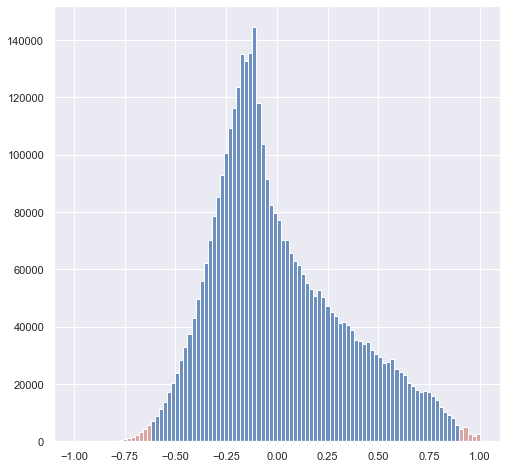

In [5]:
# Load gene-metabolite correlation matrix from file, and calculate upper and lower significance cutoffs
metExprPCC = pd.read_csv(filepath_or_buffer="metExprPCC.csv", header=0, index_col=0)
metExprList = (metExprPCC.to_numpy()).flatten()
lowCutoff = np.percentile(metExprList, 0.5)
highCutoff = np.percentile(metExprList, 99.5)

n, bins, patches = plt.hist(metExprList, bins=100, range=[-1, 1])
for c, p in zip(bins, patches):
    if c < lowCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
    elif c >= lowCutoff and c < highCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[0])
    else:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
plt.show()

In [6]:
# Filter out any genes which have no significant metabolite associations.
genesToDrop = list(set(exprDataTF.index) - set(metExprPCC.columns))
filteredMetExprPCC = copy.deepcopy(metExprPCC)

# Filter for significant genes with at least 1 association.
for col in range(0, metExprPCC.shape[1]):
    if sum(filteredMetExprPCC.iloc[:, col] > highCutoff) == 0 and sum(filteredMetExprPCC.iloc[:, col] < lowCutoff) == 0:
        genesToDrop.append(filteredMetExprPCC.columns[col])
filteredMetExprPCC = filteredMetExprPCC.drop(genesToDrop, axis=1, errors="ignore")
exprDataTF = exprDataTF.drop(genesToDrop, axis=0, errors="ignore") # also drop from expression dataframe

# Use metExprPCC to separate exprData dataframe into genes with positive associations and genes with negative associations. Add column to separated data for cluster info - gene cluster should be the metabolite cluster which the metabolite the gene was most strongly associated with belongs.
exprDataTF.insert(0, "Cluster", np.nan)
exprDataPositive = pd.DataFrame(columns=exprDataTF.columns)
exprDataNegative = pd.DataFrame(columns=exprDataTF.columns)
for col in range(0, filteredMetExprPCC.shape[1]):
    geneID = filteredMetExprPCC.columns[col]
    metID = filteredMetExprPCC.iloc[:, col].abs().idxmax()
    exprDataTF.loc[geneID, "Cluster"] = metDataTF.loc[metID, "Cluster"]
    if sum(filteredMetExprPCC.iloc[:, col] > highCutoff):
        geneID = filteredMetExprPCC.columns[col]
        exprDataPositive = exprDataPositive.append(exprDataTF.loc[geneID])
        metID = filteredMetExprPCC.iloc[:, col].idxmax()
        exprDataPositive.loc[geneID, "Cluster"] = metDataTF.loc[metID, "Cluster"]
    if sum(filteredMetExprPCC.iloc[:, col] < lowCutoff):
        geneID = filteredMetExprPCC.columns[col]
        exprDataNegative = exprDataNegative.append(exprDataTF.loc[geneID])
        metID = filteredMetExprPCC.iloc[:, col].idxmin()
        exprDataNegative.loc[geneID, "Cluster"] = metDataTF.loc[metID, "Cluster"]

exprDataTF.to_csv(path_or_buf="exprDataCombined.csv")
exprDataPositive.to_csv(path_or_buf="exprDataPositive.csv")
exprDataNegative.to_csv(path_or_buf="exprDataNegative.csv")

In [7]:
# Summarize gene and metabolite data into averages for each cluster and create line graphs comparing gene expression data to metabolite accumulation for each cluster
meanExprDataPositive = exprDataPositive.drop(exprDataPositive.iloc[:, 1:6], axis=1)
meanExprDataPositive = meanExprDataPositive.groupby("Cluster").mean()
meanExprDataPositive.reset_index(level=0, inplace=True)
meanExprDataPositive["Type"] = "Positively associated genes"
meanExprDataPositive["Row"] = np.repeat([0,1], [3,3], axis=0) # for drawing faceted graphs
meanExprDataPositive["Col"] = [0,1,2]*2 # for drawing faceted graphs

meanExprDataNegative = exprDataNegative.drop(exprDataNegative.iloc[:, 1:6], axis=1)
meanExprDataNegative = meanExprDataNegative.groupby("Cluster").mean()
meanExprDataNegative.reset_index(level=0, inplace=True)
meanExprDataNegative["Type"] = "Negatively associated genes"
meanExprDataNegative["Row"] = np.repeat([0,1], [3,3], axis=0) # for drawing faceted graphs
meanExprDataNegative["Col"] = [0,1,2]*2 # for drawing faceted graphs

meanMetData = metDataTF.drop(metDataTF.iloc[:, 1:metDataTF.shape[1]-20], axis=1)
meanMetData = meanMetData.groupby("Cluster").mean()
meanMetData.reset_index(level=0, inplace=True)
meanMetData["Type"] = "Metabolites"
meanMetData["Row"] = np.repeat([0,1], [3,3], axis=0) # for drawing faceted graphs
meanMetData["Col"] = [0,1,2]*2 # for drawing faceted graphs

plotData = pd.concat([meanExprDataPositive, meanExprDataNegative, meanMetData], axis=0)
plotData = pd.melt(plotData, id_vars=["Cluster", "Row", "Col", "Type"], var_name="Sample", value_name="Z-score")

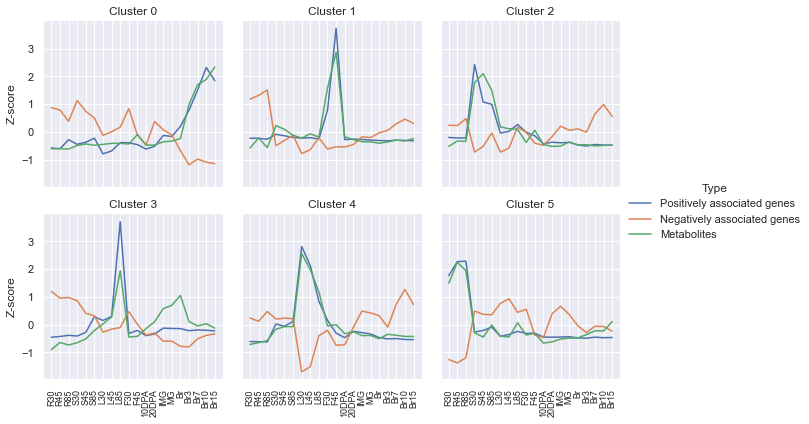

In [8]:
clusterPlot = sns.FacetGrid(plotData, row="Row", col="Col", hue="Type", legend_out=True)
clusterPlot.map(sns.lineplot, "Sample", "Z-score")
clusterPlot.set(xlabel=None)
clusterPlot.set_xticklabels(rotation=90, size=9)
clusterPlot.add_legend()
for ax, title in zip(clusterPlot.axes.flat, ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"]):
    ax.set_title(title)

In [31]:
# Create a dataframe with significant metabolite-genes associations and save for use later - this will be "edge" data in the network.
metExprEdges = pd.DataFrame(columns=["Gene", "Metabolite", "Direction"])
for row in range(0, filteredMetExprPCC.shape[0]):
    for col in range(0, filteredMetExprPCC.shape[1]):
        if filteredMetExprPCC.iloc[row, col] > highCutoff:
            metExprEdges = metExprEdges.append({"Gene":filteredMetExprPCC.columns[col], "Metabolite":filteredMetExprPCC.index[row], "Direction":"+"}, ignore_index=True)
        elif filteredMetExprPCC.iloc[row, col] < lowCutoff:
            metExprEdges = metExprEdges.append({"Gene":filteredMetExprPCC.columns[col], "Metabolite":filteredMetExprPCC.index[row], "Direction":"-"}, ignore_index=True)
metExprEdges.to_csv(path_or_buf="metExprEdges.csv")

To calculate gene-gene associations, a similar workflow as that applied in Project 1 will be used here. The only major difference is that I'll use numpy's built-in function for calculating PCC instead of creating a function myself.

In [9]:
# Create correlation matrix for gene-gene interactions
# Regenerate expression data array from filtered genes
onlyExprDataTF = np.array(exprDataTF.iloc[:, exprDataTF.shape[1]-20:exprDataTF.shape[1]])
exprPCC = np.zeros(shape=(onlyExprDataTF.shape[0], onlyExprDataTF.shape[0]))
for row in range(0, exprPCC.shape[0]):
    for col in range(0, exprPCC.shape[1]):
        exprPCC[row, col] = np.corrcoef(onlyExprDataTF[row, :], onlyExprDataTF[col, :])[1, 0]
exprPCC = pd.DataFrame(data=exprPCC, index=exprDataTF.index, columns=exprDataTF.index)
exprPCC.to_csv(path_or_buf="metaboliteSubsetExprPCC.csv")

NameError: name 'subsetExprDataTF' is not defined

In [14]:
#exprPCC = pd.read_csv(filepath_or_buffer="exprPCC.csv")

exprList = np.triu(exprPCC.to_numpy(), k=1)
exprList = exprList.flatten()
exprList = exprList[exprList!=0]

lowCutoff = np.percentile(exprList, 1)
highCutoff = np.percentile(exprList, 95)

n, bins, patches = plt.hist(exprList, bins=100, range=[-1, 1])
for c, p in zip(bins, patches):
    if c < lowCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
    elif c >= lowCutoff and c < highCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[0])
    else:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
plt.show()

MemoryError: Unable to allocate 732. MiB for an array with shape (9795, 9795) and data type float64

I'll save any gene-gene association which fall above the upper threshold, or below the lower threshold. To a dataframe, I'll log the 2 genes involved in each association, as well as whether the correlation was positive or negative. I'll save this "edge" dataframe to the preprocessedData folder.

In [28]:
# Create a dataframe with gene-gene edges and save
upperExprPCC = pd.DataFrame(np.triu(exprPCC.to_numpy(), k=1), index=exprPCC.index, columns=exprPCC.columns)
exprEdges = pd.DataFrame(columns=["Gene1", "Gene2", "Direction"])
for row in range(0, upperExprPCC.shape[0]):
    for col in range(0, upperExprPCC.shape[1]):
        if upperExprPCC.iloc[row, col] > highCutoff:
            exprEdges = exprEdges.append({"Gene1":upperExprPCC.index[row], "Gene2":upperExprPCC.columns[col], "Direction":"+"}, ignore_index=True)
        elif upperExprPCC.iloc[row, col] < lowCutoff:
            exprEdges = exprEdges.append({"Gene1":upperExprPCC.index[row], "Gene2":upperExprPCC.columns[col], "Direction":"-"}, ignore_index=True)
exprEdges = exprEdges.drop_duplicates() # If run is split up, need to remove duplicates
exprEdges.to_csv(path_or_buf="networkData/exprEdgesCombined.csv")


In [34]:
# Filter edge dataset into 2 separate files for positive and negative gene-metabolite associations
exprEdgesPositive = exprEdges[exprEdges.Gene1.isin(subsetExprDataPositive.index)]
exprEdgesPositive = exprEdgesPositive[exprEdgesPositive.Gene2.isin(subsetExprDataPositive.index)]
exprEdgesPositive.to_csv(path_or_buf="networkData/exprEdgesPositive.csv")

exprEdgesNegative = exprEdges[exprEdges.Gene1.isin(subsetExprDataNegative.index)]
exprEdgesNegative = exprEdgesNegative[exprEdgesNegative.Gene2.isin(subsetExprDataNegative.index)]
exprEdgesNegative.to_csv(path_or_buf="networkData/exprEdgesNegative.csv")